# Nacrt pobiranja izrabljenih pnevmatik na območju slovenije

Najprej uvozimo vse zbirne centre, vulkanizerje ter servise v Sloveniji ter določimo koordinate predvidenega zbirališča.

In [1]:
import pandas as pd
from models import Podjetje, Naslov, Pot
import csv
import json
from math import sin, cos, sqrt, atan2
import random
from geopy.distance import distance

zbirni_centri = pd.read_csv('komunale.csv')

vulkanizerji = pd.read_csv('vulkanizerji_in_servisi.csv')

zbiralisce = (46.02357995,14.42064616)

pd.options.display.max_rows = 10

Ideja načrta je, da se razdeli vulkanizerje ter servise v 3 razrede na podlagi letne količine pnevmatik. Člani višjega razreda dobijo svoj zabojnik, srednji in nižji razred pa si organizirata prevoz z kombiji do najbližjega zbirnega centra. 

Najbližji zbirni center posameznega vulkanizerja/servisa določimo na podlagi geografskih koordinat. Najbližji zbirni center je torej tisti, ki je od posameznika glede na letalsko linijo najmanj oddaljen. Za natančen izračun razdalj bomo uporabili knjižnico geopy.

In [2]:
def najblizji_center(koordinate):
    zbirni_centri["razdalje"] = zbirni_centri.apply(lambda x: float(distance(koordinate, x['koordinate']).km), axis=1)
    index = zbirni_centri.razdalje.idxmin()
    return index

# za vsakega vulkanizerja nastavimo najblizji center 
# funkcija traja nekaj casa saj racuna za vsakega vse razdalje (30s)
vulkanizerji['zbirni_center'] = vulkanizerji.koordinate.str.split(';').apply(najblizji_center)

# izbrisemo nastali stolpec 
del zbirni_centri['razdalje']



Za izračun stroškov prevoza je potrebno upoštevati razdaljo za izračun stroškov goriva ter dolžino avtoceste za izračun stroškov cestnine.
Zato razdelimo pot na dele ter za vsak del pogledamo če je avtocesta, ter vse take dele seštejemo.

In [38]:
avtoceste = ['A1','A2','A3','A4','A5','A1:A2']

def dolzina_avtoceste(pot):
    avtocesta = 0
    if isinstance(pot,str):
        locena_pot = pot.split('--')
        for delna_pot in locena_pot:
            razbitje = delna_pot.split(";")
            if razbitje[0] in avtoceste:
                avtocesta += float(razbitje[1])
    return avtocesta

zbirni_centri['avtocesta'] = zbirni_centri.pot.apply(dolzina_avtoceste)
vulkanizerji['avtocesta'] = vulkanizerji.pot.apply(dolzina_avtoceste)



Določitev stroškov prevoza do posameznega vulkanizerja in zbirnega centra:

In [39]:
CESTNINA = 0.428356
PORABA_KAMIJONA = 35
CENA_GORIVA = 1.242

vulkanizerji['strosek_kamijona'] = 2 * vulkanizerji.dolzina * (PORABA_KAMIJONA / 100 * CENA_GORIVA) + 2 * CESTNINA * vulkanizerji.avtocesta
zbirni_centri['strosek_kamijona'] = 2 * zbirni_centri.dolzina * (PORABA_KAMIJONA / 100 * CENA_GORIVA) + 2 * CESTNINA * zbirni_centri.avtocesta


Po načrtu bi vsak večji vulkanizer imel svoj zabojnik. Vulkanizerje razdelimo po velikost nakljucno v vsaki regiji posebej na podlagi podanih delezov vsake kategorije.

In [40]:
DELEZ_KAMIJONSKIH = 0.25
STEVILO_ODPADNIH_LETNO = 16000 * (1 - DELEZ_KAMIJONSKIH) # V tonah
DELEZ_ODPADNIH_V_KOMUNALAH = 0.1
STEVILO_ODPADNIH_LETNO_VULKANIZERJI = STEVILO_ODPADNIH_LETNO * (1 - DELEZ_ODPADNIH_V_KOMUNALAH) # V tonah
STEVILO_ODPADNIH_LETNO_KOMUNALE = STEVILO_ODPADNIH_LETNO * DELEZ_ODPADNIH_V_KOMUNALAH # V tonah

TEŽA_PNEVMATIKE = 8 # V kilogramih
# DELEZI VULKANIZERJEV PO VELIKOSTI V VSAKI REGIJI:

DELEZ_VELIKIH = 0.10
DELEZ_SREDNJIH = 0.65
DELEZ_MALIH = 0.25

stevilo_vulkanizerjov = len(vulkanizerji.index)
stevilo_komunal = len(zbirni_centri.index)

indexi_velikosti = {index: None for index in vulkanizerji.index.unique().to_list()}

regije = vulkanizerji.regija.unique().tolist()

for regija in regije:
    vulkanizerji_regije = vulkanizerji[vulkanizerji.regija == regija]
    stevilo = len(vulkanizerji_regije.index)
    indexi = vulkanizerji_regije.index.unique().tolist()
    stevila = {
        'V': round(stevilo * DELEZ_VELIKIH),
        'M': round(stevilo * DELEZ_MALIH),
        'S': stevilo - round(stevilo * DELEZ_VELIKIH) - round(stevilo * DELEZ_MALIH)
    }
    for velikost in stevila:
        for n in range(stevila[velikost]):
            index = random.choice(indexi)
            indexi_velikosti[index] = velikost
            indexi.remove(index)

def dodaj_velikost(index):
    return indexi_velikosti[index]

vulkanizerji['velikost'] = vulkanizerji.index.to_series().apply(dodaj_velikost)



Pri komunalah je malo drugače saj so za razliko od vulkanizerjev, katerih je v večjih mestih več, le te večje. Zato jih razdelimo v dva razreda na podlagi pripadajočemu mestu.

In [41]:
VEČJA_MESTA = ['Ljubljana',"Maribor","Celje","Kranj","Koper","Novo mesto"]

def doloci_velikost_centra(mesto):
    if mesto in VEČJA_MESTA:
        return "V"
    else:
        return "M"

zbirni_centri["velikost"] = zbirni_centri.mesto.apply(doloci_velikost_centra)

Nadalnje je treba določiti letno količino posameznika. To naredimo tako, da določimo odstopanje posameznega razreda od letnega povprečja.

In [42]:
povprecje_letno = STEVILO_ODPADNIH_LETNO_VULKANIZERJI / stevilo_vulkanizerjov

delezi = {'V':2,'S':1,'M':0.5}
velikosti = ['V','S','M']

stevilo_po_velikosti = {velikost:0 for velikost in velikosti}

for velikost in velikosti:
    stevilo_po_velikosti[velikost] = (len(vulkanizerji[vulkanizerji.velikost == velikost]))

letno = 0
for velikost in velikosti:
    letno += povprecje_letno * delezi[velikost] * stevilo_po_velikosti[velikost]

razlika = povprecje_letno * stevilo_vulkanizerjov - letno
for velikost in velikosti:
    delezi[velikost] += 0.01 * razlika / povprecje_letno

def vrni_letno_stevilo(velikost):
    return round(povprecje_letno * delezi[velikost] * 1000 / TEŽA_PNEVMATIKE)

vulkanizerji['letna_kolicina'] = vulkanizerji.velikost.apply(vrni_letno_stevilo)



Na podoben način določimo letno kolicino posamezne komunale.

In [43]:
povprecje_letno = STEVILO_ODPADNIH_LETNO_KOMUNALE / stevilo_komunal

delezi = {'V': 4, 'M':0.8}
velikosti = ['V','M']

# Stevilo clanov posamezne skupine velikosti:

stevilo_po_velikosti = {velikost:0 for velikost in velikosti}

for velikost in velikosti:
    stevilo_po_velikosti[velikost] = (len(zbirni_centri[zbirni_centri.velikost == velikost]))

# Popravek/Prilagoditev delezev:
letno = 0
for velikost in velikosti:
    letno += povprecje_letno * delezi[velikost] * stevilo_po_velikosti[velikost]

razlika = STEVILO_ODPADNIH_LETNO_KOMUNALE - letno
for velikost in velikosti:
    delezi[velikost] += 0.01 * razlika / povprecje_letno

def vrni_letno_stevilo(velikost):
    return round(povprecje_letno * delezi[velikost] * 1000 / TEŽA_PNEVMATIKE)

zbirni_centri['letna_kolicina'] = zbirni_centri.velikost.apply(vrni_letno_stevilo)

Ker vsi srednji in majhni vulkanizerji vozijo v najblizji zbirni center je treba vsakemu zbirnemu centru k letni kolicini pristeti se letno kolicino vseh pripadnih vulkanizerjev

In [44]:
def sestevek_vulkanizerjev(index):
    return vulkanizerji[
    (vulkanizerji.zbirni_center == index) & (vulkanizerji.velikost != "V")
    ].letna_kolicina.sum()

zbirni_centri['letna_kolicina'] = zbirni_centri.letna_kolicina + zbirni_centri.letna_kolicina.index.map(sestevek_vulkanizerjev)


Sedaj ko imamo vse podatke lahko zacnemo racunati stroske prevoza.

In [45]:
KAPACITETA_KAMIJONA = 1200

# zdruzimo komunale in velike vulkanizerje

veliki_vulkanizerji = vulkanizerji[vulkanizerji.velikost == "V"]

pobiranje = pd.concat([zbirni_centri,veliki_vulkanizerji],ignore_index=True, sort=False)

pobiranje['letni_stroski'] = pobiranje.letna_kolicina // KAPACITETA_KAMIJONA * pobiranje.strosek_kamijona


Stroske bomo racunali v odvisnosti od polmera pobiranja okoli zbirnega centra. Ustvarimo tabelo, katera pokaze stroske prevoza, kolicino pobranih pnevmatik, ter količino časa porabljenega na cesti v obdobju enega leta.

In [46]:
def stroski_na_razdalji(razdalja):
    return pobiranje[pobiranje.dolzina <= razdalja].letni_stroski.sum()

def stevilo_na_razdalji(razdalja):
    return pobiranje[pobiranje.dolzina <= razdalja].letna_kolicina.sum()

def trajanje_na_razdalji(razdlaja):
    return (pobiranje[pobiranje.dolzina <= razdalja].trajanje * pobiranje.letna_kolicina // KAPACITETA_KAMIJONA * 2).sum()

skupno = pd.DataFrame({'razdalja':[],'strosek':[],'stevilo':[],'trajanje':[]})

i = 0
for razdalja in range(5,201,5):
    skupno.at[str(i),'razdalja'] = razdalja
    skupno.at[str(i),'strosek'] = stroski_na_razdalji(razdalja)
    skupno.at[str(i),'stevilo'] = stevilo_na_razdalji(razdalja)
    skupno.at[str(i),'trajanje'] = trajanje_na_razdalji(razdalja) / 60
    i+=1



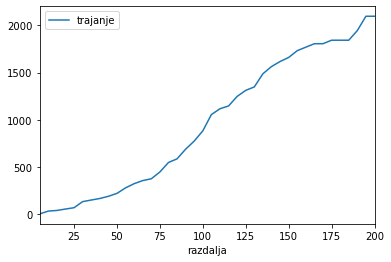

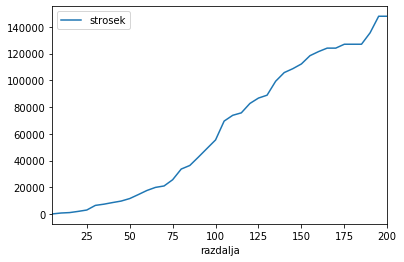

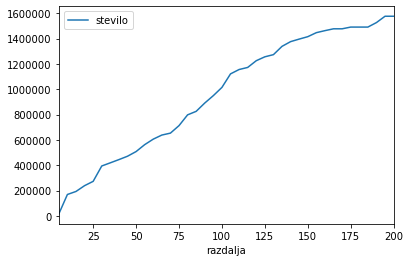

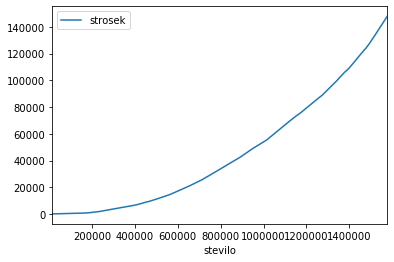

In [47]:
import matplotlib.pyplot as plt

skupno.plot(x='razdalja',y="trajanje")
skupno.plot(x='razdalja',y="strosek")
skupno.plot(x='razdalja',y="stevilo")
skupno.plot(x="stevilo",y="strosek")

Če določimo trajanje obdelave določene količine pnevmatik v urah lahko izračunamo še strošek zaposlenih.

In [48]:
DELEŽ_DOBRIH = 0.15

POTREBEN_ČAS_ZA_OBDELAVO_DOBRIH = 30 # v urah na 1000 komadov
POTREBEN_ČAS_ZA_OBDELAVO_NEUPORABNIH = 5 # v urah na 1000 komadov

skupno['cas_obdelave'] = (
    skupno['stevilo'] * DELEŽ_DOBRIH / 1000 * POTREBEN_ČAS_ZA_OBDELAVO_DOBRIH +
    skupno['stevilo'] * (1 - DELEŽ_DOBRIH) / 1000 * POTREBEN_ČAS_ZA_OBDELAVO_NEUPORABNIH)
    
STROŠEK_ENE_URE = 10 # bruto placa zaposlenega v evrih na uro

skupno['strosek'] = skupno['strosek'] + (skupno['cas_obdelave'] + skupno['trajanje']) * STROŠEK_ENE_URE


Če določimo pričakov prihodek na eno dobro pnevmatiko lahko izračunamo prihodke v odvisnosti od radija pobiranja.

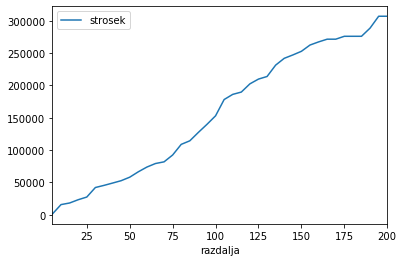

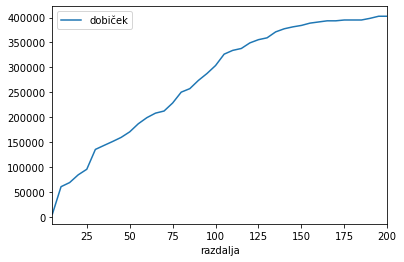

In [50]:
PRIČAKOVAN_PRIHODEK = 3 # v evrih na eno dobro pnevmatiko

skupno['prihodek'] = skupno['stevilo'] * DELEŽ_DOBRIH * PRIČAKOVAN_PRIHODEK

skupno['dobiček'] = skupno['prihodek'] - skupno['strosek']

skupno.plot(x='razdalja',y="strosek")
skupno.plot(x="razdalja",y="dobiček")

Iz grafa je razvidno, da je najboljši radij pobiranja okoli 100km, zato sklepamo, da bi za uresničitev načrta in maksimizacijo prihodkov na območju celotne Slovenije, bilo potrebno odprti dve večji zbirališči, eno na jugo-zahodnem območju Ljubljane in drugo na območju Maribora.